In [5]:
import pandas as pd
import numpy as np
import mysql.connector
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [6]:
# Connecting to the database
load_dotenv()
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cur = conn.cursor()
cur.close()

True

__Extract data__   
	- • The client's ID.  
	- • Date and time of the start of the booking.  
	- • The date and time of the end of the booking.  
	- • Number of rental hours.  
	- • The cost of rent.

In [7]:
query = """SELECT 
    o.id,
    o.workplace_id,
    o.client_id,
    CASE 
        WHEN dc.main_id IS NOT NULL THEN dc.main_id 
        ELSE o.client_id 
    END AS main_id,
    o.payment_id,
    o.schedule_start,
    o.schedule_end,
    TIMESTAMPDIFF(HOUR, o.schedule_start, o.schedule_end) AS duration,
    o.type, 
    o.workplace_type,
    o.user_id,
    c.first_name,
    c.last_name,
    c.phone,
    c.email,
    p.price,
    p.amount
FROM orders o
LEFT JOIN clients c ON o.client_id = c.id
LEFT JOIN payments_meta p ON o.id = p.order_id AND o.payment_id = p.payment_id
LEFT JOIN (
    SELECT MIN(c.id) AS main_id, REPLACE(c.phone, '+7', '8') AS phone_norm
    FROM clients c
    GROUP BY REPLACE(c.phone, '+7', '8')
) dc ON REPLACE(c.phone, '+7', '8') = dc.phone_norm
WHERE o.schedule_start > "2023-01-01" and o.schedule_start < "2025-04-01" 
ORDER BY o.client_id;"""

orders_clients = pd.read_sql(query, conn)

In [8]:
# Сonverting to the datetime format

orders_clients['schedule_start'] = pd.to_datetime(orders_clients['schedule_start'])
orders_clients['schedule_end'] = pd.to_datetime(orders_clients['schedule_end'])

In [9]:
orders_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13009 entries, 0 to 13008
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              13009 non-null  int64         
 1   workplace_id    13009 non-null  int64         
 2   client_id       13009 non-null  int64         
 3   main_id         13009 non-null  int64         
 4   payment_id      13009 non-null  int64         
 5   schedule_start  13009 non-null  datetime64[ns]
 6   schedule_end    13009 non-null  datetime64[ns]
 7   duration        13009 non-null  int64         
 8   type            13009 non-null  object        
 9   workplace_type  13009 non-null  object        
 10  user_id         13009 non-null  int64         
 11  first_name      13001 non-null  object        
 12  last_name       13001 non-null  object        
 13  phone           13001 non-null  object        
 14  email           13001 non-null  object        
 15  pr

In [30]:
# Extract year and month from the start date
orders_clients['ym_start'] = orders_clients['schedule_start'].dt.to_period('M')

### __Cohorts__  
#### When and how fast different customer groups dropped off after their first visit?

In [31]:
# First oder date
orders_clients['first_dt'] = orders_clients.groupby('main_id')['schedule_start'].transform('min')

# Extract year and mnth from first oder date
orders_clients['first_ym'] = orders_clients['first_dt'].dt.to_period('M')
orders_clients.head()

,id,workplace_id,client_id,main_id,payment_id,schedule_start,schedule_end,duration,type,workplace_type,user_id,first_name,last_name,phone,email,price,amount,ym_start,first_dt,first_ym
0,56316,264,0,0,56391,2023-04-21 12:30:00,2023-04-21 15:00:00,2,hourly,workplace,38,None,None,None,None,625.0,625.0,2023-04,2023-04-21 12:30:00,2023-04
1,56609,265,0,0,56678,2023-04-30 12:00:00,2023-04-30 14:00:00,2,hourly,workplace,38,None,None,None,None,500.0,500.0,2023-04,2023-04-21 12:30:00,2023-04
2,56610,266,0,0,56679,2023-04-30 12:00:00,2023-04-30 14:00:00,2,hourly,workplace,38,None,None,None,None,600.0,600.0,2023-04,2023-04-21 12:30:00,2023-04
3,56315,266,0,0,56390,2023-04-21 12:30:00,2023-04-21 15:00:00,2,hourly,workplace,38,None,None,None,None,750.0,750.0,2023-04,2023-04-21 12:30:00,2023-04
4,56314,266,0,0,56389,2023-04-21 12:30:00,2023-04-21 15:00:00,2,hourly,workplace,38,None,None,None,None,750.0,750.0,2023-04,2023-04-21 12:30:00,2023-04


In [32]:

cohorts = pd.pivot_table(
    orders_clients,
    index = 'first_ym',
    columns = 'ym_start',
    values = 'main_id',
    aggfunc = 'nunique' 
    ).fillna(0).astype(int)

diags = np.diag(cohorts)
cohorts = cohorts.div(diags, axis = 0).round(2) 

cohorts.head()

ym_start,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,...,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03
first_ym,,,,,,,,,,,,,,,,,,,,,
2023-01,1.0,0.75,0.78,0.65,0.67,0.57,0.62,0.67,0.55,0.53,...,0.42,0.45,0.40,0.37,0.38,0.37,0.42,0.37,0.37,0.35
2023-02,0.0,1.00,0.26,0.19,0.23,0.13,0.23,0.13,0.06,0.13,...,0.19,0.10,0.23,0.13,0.16,0.06,0.13,0.16,0.13,0.06
2023-03,0.0,0.00,1.00,0.19,0.25,0.06,0.06,0.00,0.06,0.12,...,0.12,0.12,0.12,0.06,0.19,0.12,0.06,0.12,0.06,0.12
2023-04,0.0,0.00,0.00,1.00,0.23,0.14,0.09,0.05,0.05,0.09,...,0.05,0.05,0.00,0.00,0.05,0.00,0.00,0.05,0.00,0.00
2023-05,0.0,0.00,0.00,0.00,1.00,0.33,0.22,0.22,0.22,0.11,...,0.11,0.11,0.11,0.22,0.11,0.11,0.11,0.00,0.11,0.00


#### Visualisation

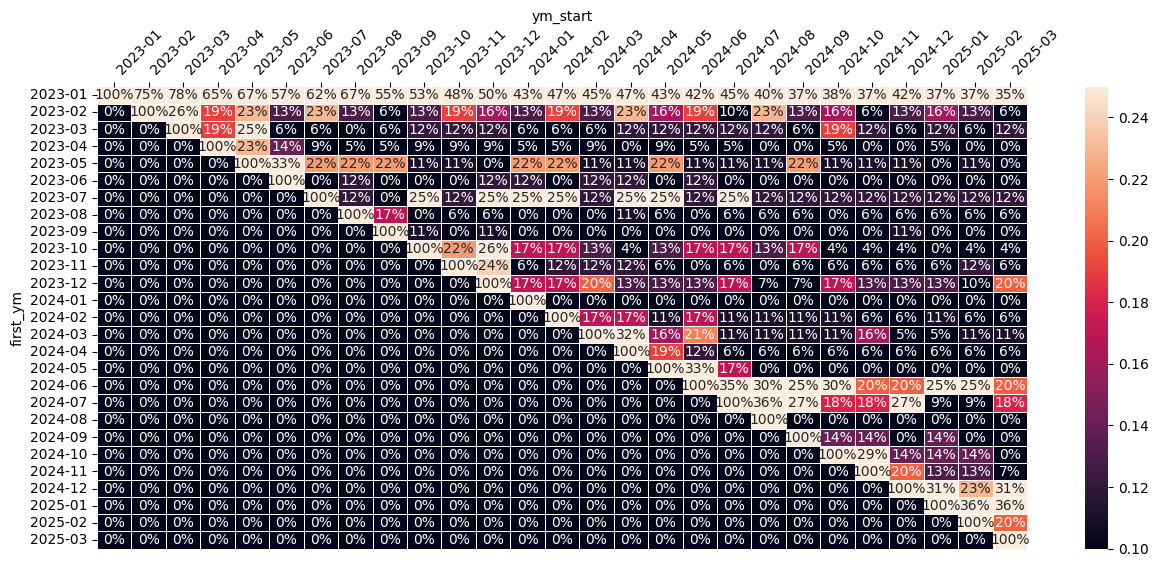

In [34]:

f, ax = plt.subplots(figsize=(15, 6))

sns.heatmap(
    cohorts,
    annot=True,    
    fmt='.0%',     
    linewidth=0.5,  
    vmin=0.1,      
    vmax=np.percentile(cohorts, 90), 
);

ax.xaxis.set_label_position('top');  
ax.xaxis.tick_top();            

plt.xticks(rotation=45, ha='left');

### __RFM - analysis__

#### Build an RFM table

In [19]:
# define the "current date" for analysis (for example, the most recent order in the table + 1 day)
reference_date = orders_clients['schedule_start'].max() + pd.Timedelta(days=1)

rfm = orders_clients.groupby('main_id').agg({
    'schedule_start': lambda x: (reference_date - x.max()).days,   # Recency
    'id': 'count',                                                 # Frequency
    'amount': 'mean'                                               # Monetary
}).reset_index()

rfm.columns = ['main_id', 'recency', 'frequency', 'monetary']

rfm

,main_id,recency,frequency,monetary
0,0,702,7,653.571429
1,461,711,2,625.000000
2,479,231,4,1887.500000
3,670,17,156,909.902597
4,679,8,2286,453.300745
...,...,...,...,...
415,13482,24,1,700.000000
416,13487,26,1,350.000000
417,13488,17,1,300.000000
418,13489,19,1,600.000000


In [20]:
rfm.describe()

,main_id,recency,frequency,monetary
count,420.000000,420.000000,420.000000,420.000000
mean,10892.254762,349.761905,30.973810,637.320196
std,3886.525689,254.041341,147.357218,420.686135
min,0.000000,1.000000,1.000000,125.000000
25%,12030.250000,94.750000,1.000000,375.000000
50%,12595.500000,346.000000,2.000000,525.000000
75%,13079.500000,562.250000,10.000000,750.000000
max,13490.000000,815.000000,2286.000000,4692.552083


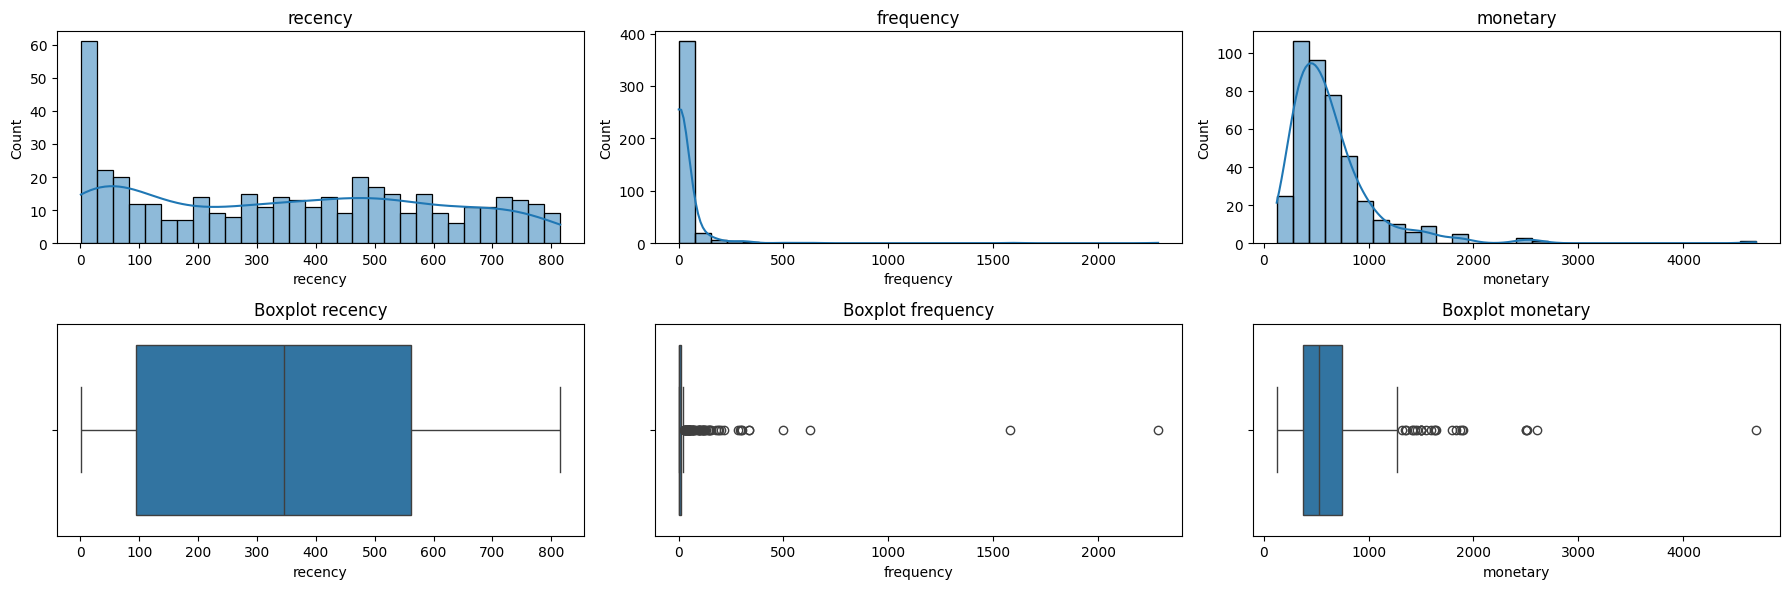

In [21]:

plt.figure(figsize=(18, 6))

for i, col in enumerate(['recency', 'frequency', 'monetary']):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm[col], bins=30, kde=True)
    plt.title(f"{col}")

    plt.subplot(2, 3, i + 4)
    sns.boxplot(x=rfm[col])
    plt.title(f"Boxplot {col}")
    plt.tight_layout()

plt.show()

#### Defining segment boundaries

For more accuracy, a decile distribution was made.

In [22]:
# Define deciles
rfm_quantiles = rfm[['recency', 'frequency', 'monetary']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
rfm_quantiles

,recency,frequency,monetary
0.1,17.0,1.0,300.000000
0.2,59.4,1.0,350.000000
0.3,133.0,1.0,418.847561
0.4,263.2,2.0,490.545455
0.5,346.0,2.0,525.000000
0.6,443.2,3.0,600.000000
0.7,511.5,6.0,696.225490
0.8,599.6,16.0,813.461538
0.9,713.3,60.2,1050.000000


#### Recency

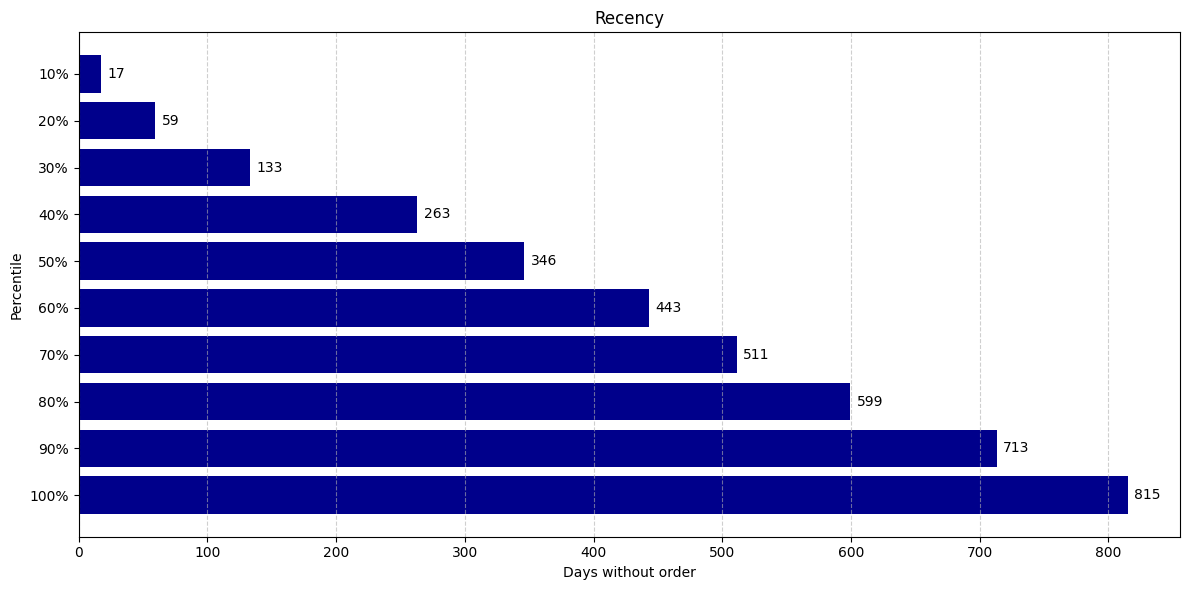

In [23]:
percentiles = np.append(np.arange(0.1, 1.0, 0.1), 1.0)
recency_values = rfm['recency'].quantile(percentiles)

recency_df = pd.DataFrame({
    'percentile': [f"{int(p * 100)}%" for p in percentiles],
    'recency': recency_values.values
})
recency_df = recency_df.sort_values(by='recency', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(recency_df['percentile'], recency_df['recency'], color='darkblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center')

plt.xlabel("Days without order")
plt.ylabel("Percentile")
plt.title("Recency")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

20% of the clients are those who booked a workplace within the last 59 days. These are the regular clients and new ones who have recently visited, and the coworking  wants them to return. This is the “freshest” group, Group 1.

The median (346 days) and the mean (349 days). Thus, 30% of the clients belong to the middle category. Group 2.

Those who haven’t visited the coworking for more than 350 days fall into Group 3, because these are either very infrequent visitors, or clients who found the location inconvenient, or those who have switched to competitors.

#### Frequency

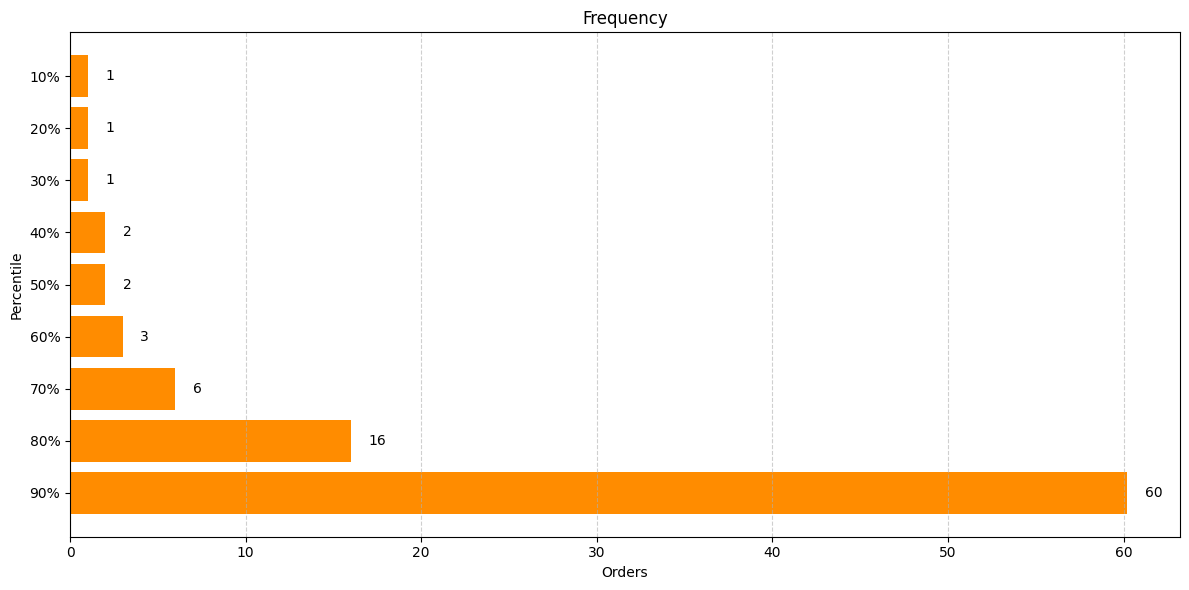

In [24]:
percentiles = np.arange(0.1, 1.0, 0.1)
frequency_values = rfm['frequency'].quantile(percentiles)

frequency_df = pd.DataFrame({
    'percentile': [f"{int(p * 100)}%" for p in percentiles],
    'frequency': frequency_values.values
})
frequency_df = frequency_df.sort_values(by='percentile', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(frequency_df['percentile'], frequency_df['frequency'], color='darkorange')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center')

plt.xlabel("Orders")
plt.ylabel("Percentile")
plt.title("Frequency")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A significant portion of clients (30%) made only one purchase during the entire period. These are the “coldest” clients, and thus belong to Group 3.

Another 30% of clients made only 2–3 purchases. This means that half of the customer base shows very low activity (1–2 purchases). This is a key area for improving retention — Group 2.

The remaining customers are the most engaged and active ones — they belong to Group 1.

#### Monetary

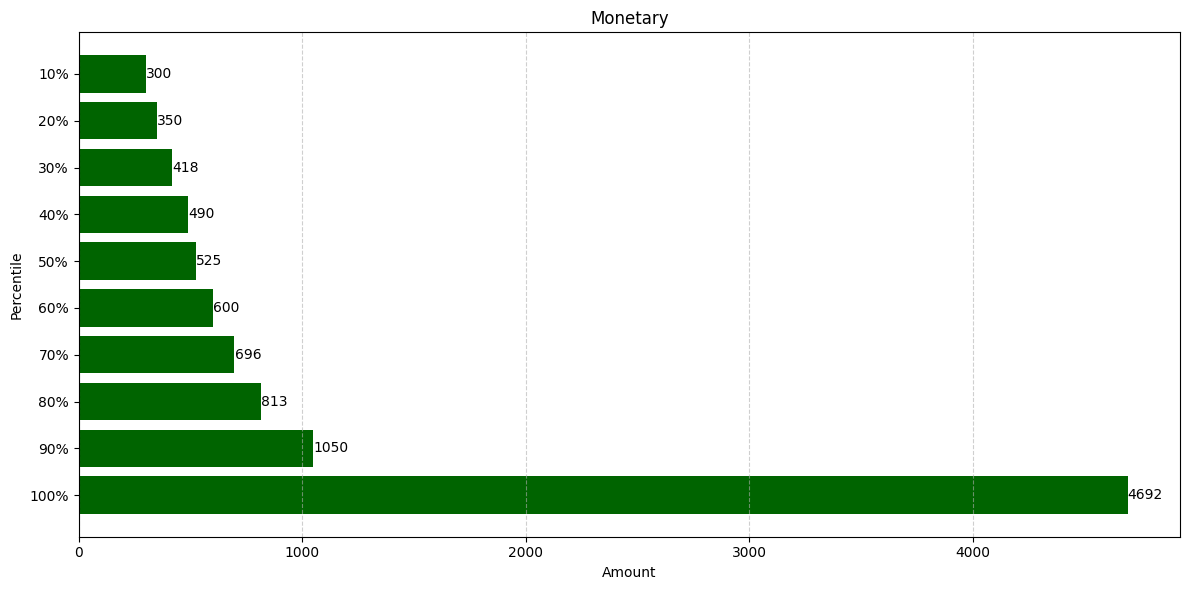

In [25]:
percentiles = np.append(np.arange(0.1, 1.0, 0.1), 1.0)
monetary_values = rfm['monetary'].quantile(percentiles)

monetary_df = pd.DataFrame({
    'percentile': [f"{int(p * 100)}%" for p in percentiles],
    'monetary': monetary_values.values
})
monetary_df = monetary_df.sort_values(by='monetary', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(monetary_df['percentile'], monetary_df['monetary'], color='darkgreen')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center')

plt.xlabel("Amount")
plt.ylabel("Percentile")
plt.title("Monetary")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

30% of clients still fall into the low revenue zone — spending less than 420 ₽.
This may indicate that a large number of clients do not return or use the service very occasionally. Group 3

Another 50% of clients spend less than 800 ₽.
This suggests that the average check or the number of orders for most clients is relatively low. Group 2

The top 20% of clients already spend more than 800 ₽ — that’s 2–3 times more than the median client.
This is a valuable segment. Group 1

#### Summary

| Segment | Recency (Days Since Last Order) | Frequency (Number of Orders) | Monetary (Amount) |
|---------|------------------------------------|----------------------------------|-----------------------------|
| 1       | Order made 59 or fewer days ago | 6 or more orders              | 800 ₽ or more              |
| 2       | Order made 350 days or fewer                  | 3–6 orders                    | 420–800 ₽                  |
| 3       | Order made more than 350 days ago | 1–2 orders (very rarely)   | 420 ₽ or less              |

##### Counting the number of customers in each segment

In [26]:
def recency_score(r):
    if r <= 59:
        return 1
    elif r <= 350:
        return 2
    else:
        return 3

def frequency_score(f):
    if f >= 6:
        return 1
    elif 3 <= f <= 5:
        return 2
    else:
        return 3

def monetary_score(m):
    if m >= 800:
        return 1
    elif 420 < m < 800:
        return 2
    else:
        return 3

rfm['R'] = rfm['recency'].apply(recency_score)
rfm['F'] = rfm['frequency'].apply(frequency_score)
rfm['M'] = rfm['monetary'].apply(monetary_score)

rfm['segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

segment_counts = rfm['segment'].value_counts().sort_index()
segment_counts

segment
111    17
112    30
113    12
121     3
122     2
123     3
131     4
132     6
133     7
211    11
212    16
213    12
221     3
222     8
223     8
231    12
232    35
233    22
311     7
312    20
313     5
321     5
322    15
323    14
331    25
332    74
333    44
Name: count, dtype: int64

#### Сombine customers into larger segments

| Group           | Segments                                         | Description                                                                 |
|------------------|--------------------------------------------------|------------------------------------------------------------------------------|
| Super Star     | 111                                              | Recent, frequent, high amount                        |
| Loyal         | 112, 121, 122                                    | Recent, frequent or 3–6 orders, high amount          |
| Very Potential| 311                                              | Long time ago, frequent, high amount                           |
| Potential     | 211, 212, 221, 222, 231, 232                      | Irregular or infrequent, frequent or 3–6 orders, medium or high amount |
| Low Potential | 113, 123, 131, 132, 133, 213, 223                | Recent but low amount, or recent with few orders, or irregular and low |
| At Risk       | 312, 321, 322, 331, 332                          | Long time ago, previously had medium or high amount                    |
| Low Value     | 233, 323, 313, 333                                | Long time ago, low amount

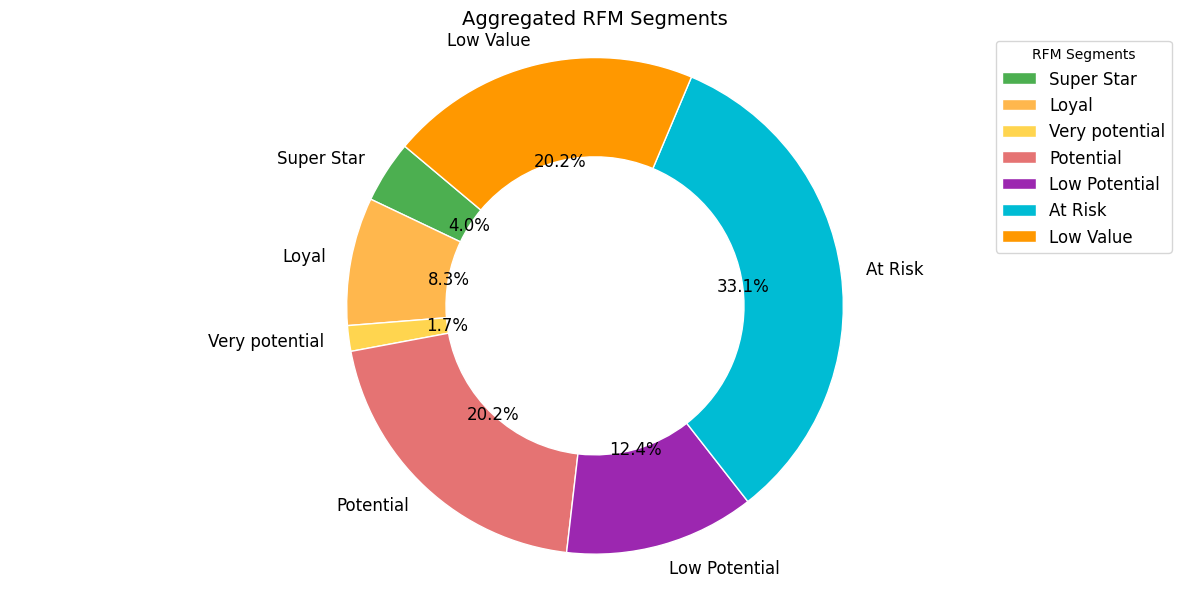

In [27]:
group_mapping = {
    'Super Star':['111'],
    'Loyal': ['112', '121', '122'],
    'Very potential':['311'],
    'Potential': [ '211', '212','221', '222','231', '232'],
    'Low Potential': ['113', '123', '131', '132', '133', '213', '223' ],
    'At Risk': ['312','321', '322','331', '332'],
    'Low Value': ['233', '323', '313', '333']
}

# Aggregating by groups
aggregated_counts = {}
for group, segments in group_mapping.items():
    aggregated_counts[group] = sum(segment_counts.get(seg, 0) for seg in segments)

plt.figure(figsize=(12, 6))
colors = ['#4CAF50', '#FFB74D', '#FFD54F', '#E57373', '#9C27B0', '#00BCD4', '#FF9800']
wedges, texts, autotexts = plt.pie(
    aggregated_counts.values(),
    labels=aggregated_counts.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    textprops=dict(color="black", fontsize=12)
)

plt.gca().add_artist(plt.Circle((0, 0), 0.3, color='white'))
plt.legend(wedges, aggregated_counts.keys(), title="RFM Segments", loc="best", fontsize=12)

plt.title("Aggregated RFM Segments", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [28]:
rfm

,main_id,recency,frequency,monetary,R,F,M,segment
0,0,702,7,653.571429,3,1,2,312
1,461,711,2,625.000000,3,3,2,332
2,479,231,4,1887.500000,2,2,1,221
3,670,17,156,909.902597,1,1,1,111
4,679,8,2286,453.300745,1,1,2,112
...,...,...,...,...,...,...,...,...
415,13482,24,1,700.000000,1,3,2,132
416,13487,26,1,350.000000,1,3,3,133
417,13488,17,1,300.000000,1,3,3,133
418,13489,19,1,600.000000,1,3,2,132


#### Summary table with a category assigned to each client

In [29]:

code_to_category = {
    code: category
    for category, codes in group_mapping.items()
    for code in codes
}

# Assign a category
rfm['segment_category'] = rfm['segment'].map(code_to_category)

client_info = orders_clients[['main_id']] \
    .groupby('main_id', as_index=False) \
    .first()
rfm = rfm.merge(client_info, on='main_id', how='left')

rfm

,main_id,recency,frequency,monetary,R,F,M,segment,segment_category
0,0,702,7,653.571429,3,1,2,312,At Risk
1,461,711,2,625.000000,3,3,2,332,At Risk
2,479,231,4,1887.500000,2,2,1,221,Potential
3,670,17,156,909.902597,1,1,1,111,Super Star
4,679,8,2286,453.300745,1,1,2,112,Loyal
...,...,...,...,...,...,...,...,...,...
415,13482,24,1,700.000000,1,3,2,132,Low Potential
416,13487,26,1,350.000000,1,3,3,133,Low Potential
417,13488,17,1,300.000000,1,3,3,133,Low Potential
418,13489,19,1,600.000000,1,3,2,132,Low Potential
